In [1]:
%matplotlib inline

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

In [2]:
import time
import pickle
from itertools import combinations_with_replacement

import numpy as np
import matplotlib.pyplot as plt

import fitsio
import tensorflow as tf

/Users/dforeman/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
sess = tf.Session()

In [4]:
labels_base = fitsio.read("data_from_andy/apogee-dr14-giants.fits")

pkl_kwds = dict(encoding="latin-1")
with open("data_from_andy/apogee-dr14-giants-flux-ivar.pkl", "rb") as fp:
    flux, ivar = pickle.load(fp, **pkl_kwds)
    
s = slice(500, 2550)
# s = slice(None)
flux = flux[:, s]
ivar = ivar[:, s]
    
label_names = ["TEFF", "LOGG", "FE_H", "C_FE", "N_FE", "ALPHA_M"]
labels = np.concatenate(
    [labels_base[n][:, None].astype(float) for n in label_names],
axis=1)
label_errs = np.concatenate(
    [labels_base[n+"_ERR"][:, None].astype(float) for n in label_names],
axis=1)

print(labels.shape, flux.shape)

np.random.seed(42)
m_train = np.random.rand(len(labels)) < 0.8
m_test = ~m_train
print(m_train.sum(), m_test.sum())

train_labels = labels[m_train]
train_label_ivar = 1.0 / label_errs[m_train]**2
train_flux = flux[m_train]
train_ivar = ivar[m_train]
test_labels = labels[m_test]
test_flux = flux[m_test]
test_ivar = ivar[m_test]

mu = np.mean(train_labels, axis=0)
std = np.std(train_labels, axis=0)

train_labels_norm = (train_labels - mu) / std
train_label_ivar_norm = train_label_ivar * std**2

(1624, 6) (1624, 2050)
1291 333


In [5]:
n_star, n_pix = train_flux.shape
n_label = train_labels.shape[1]
n_latent = n_label

In [6]:
def get_design(A, mu, std, order=2):
    A_norm = (A - mu) / std
    blocks = [np.ones((len(A), 1))]
    for order in range(1, order + 1):
        for inds in combinations_with_replacement(range(A_norm.shape[1]), order):
            blocks.append(np.product(A_norm[:, inds], axis=1)[:, None])
    return np.concatenate(blocks, axis=1)

In [7]:
Z_init = np.concatenate((
    train_labels_norm,
    np.random.randn(n_star, n_latent - n_label)
), axis=1)

label_order = 2
D = get_design(Z_init, 0.0, 1.0, order=label_order)
W_label_init = []
for i in range(n_label):
    ATA = np.dot(D.T, D * train_label_ivar_norm[:, i, None])
    w = np.linalg.solve(ATA, np.dot(D.T, train_labels_norm[:, i]*train_label_ivar_norm[:, i]))
    W_label_init.append(w)
W_label_init = np.vstack(W_label_init)

flux_order = 2
D = get_design(Z_init, 0.0, 1.0, order=flux_order)
W_flux_init = []
for i in range(n_pix):
    ATA = np.dot(D.T, D * train_ivar[:, i, None])
    w = np.linalg.solve(ATA, np.dot(D.T, train_flux[:, i]*train_ivar[:, i]))
    W_flux_init.append(w)
W_flux_init = np.vstack(W_flux_init)

In [8]:
W_label_init.shape

(6, 28)

In [9]:
W_flux_init.shape

(2050, 28)

In [10]:
F = tf.convert_to_tensor(train_flux, dtype=tf.float32)
F_ivar = tf.convert_to_tensor(train_ivar, dtype=tf.float32) 
L = tf.convert_to_tensor(train_labels, dtype=tf.float32)
L_ivar = tf.convert_to_tensor(train_label_ivar, dtype=tf.float32)

In [11]:
Z = [tf.Variable(tf.convert_to_tensor(Z_init[:, i:i+1], dtype=tf.float32),
                 name="Z_{0}".format(i))
      for i in range(n_latent)]
W_flux = [tf.Variable(tf.convert_to_tensor(W_flux_init[:, i:i+1].T, dtype=tf.float32),
                      name="W_flux_{0}".format(i))
          for i in range(W_flux_init.shape[1])]

# Predict the flux
j = 1
F_ = tf.matmul(tf.ones((n_star, 1), dtype=tf.float32), W_flux[0])
for o in range(1, flux_order + 1):
    for inds in combinations_with_replacement(range(n_latent), o):
        m = tf.ones((n_star, 1), dtype=tf.float32)
        for i in inds:
            m = tf.multiply(m, Z[i])
        F_ += tf.matmul(m, W_flux[j])
        j += 1

In [12]:
len(Z)

6

In [13]:
W_label = [tf.Variable(tf.convert_to_tensor(W_label_init[:, i:i+1].T, dtype=tf.float32),
                      name="W_label_{0}".format(i))
           for i in range(W_label_init.shape[1])]

# Predict the labels
j = 1
L_ = tf.matmul(tf.ones((n_star, 1), dtype=tf.float32), W_label[0])
for o in range(1, label_order + 1):
    for inds in combinations_with_replacement(range(n_latent), o):
        m = tf.ones((n_star, 1), dtype=tf.float32)
        for i in inds:
            m = tf.multiply(m, Z[i])
        L_ += tf.matmul(m, W_label[j])
        j += 1

In [14]:
log_jitter_pix = tf.Variable(-8.0 + tf.zeros((1, n_pix)), name="log_jitter")
log_jitter_star = tf.Variable(-8.0 + tf.zeros((n_star, 1)), name="log_jitter")
ivar = 1.0 / (1.0 / F_ivar + tf.exp(log_jitter_pix) + tf.exp(log_jitter_star))

In [15]:
# Flux likelihood
cost = tf.reduce_sum(tf.multiply(tf.square(F_ - F), ivar))
cost -= tf.reduce_sum(tf.log(ivar))

# Label likelihood
for i in range(n_label):
    cost += tf.reduce_sum(tf.multiply(tf.square(L_[:, i] * std[i] + mu[i] - L[:, i]), L_ivar[:, i]))
    
# Z prior
cost += tf.reduce_sum(tf.square(Z))
 
# Numerics
cost /= n_star * n_pix

# Gradient
all_vars = Z + W_flux + W_label + [log_jitter_pix, log_jitter_star]
var_grad = tf.gradients(cost, all_vars)

# Training
training_step = tf.train.AdamOptimizer().minimize(cost, var_list=all_vars)

In [16]:
init = tf.global_variables_initializer()

In [17]:
# with tf.Session() as sess:
sess.run(init)
cost_val = sess.run(cost)
grad_val = sess.run(var_grad)

In [18]:
cost_val

-6.6995773

In [19]:
import tqdm
cost_hist = []

sess.run(init)
for i in tqdm.trange(10000):
    sess.run(training_step)
    cost_hist.append(sess.run(cost))

Z_res = sess.run(Z)
W_flux_res = sess.run(W_flux)
W_label_res = sess.run(W_label)
F_res = sess.run(F_)
L_res = sess.run(L_)
log_jitter_pix_res = sess.run(log_jitter_pix)
log_jitter_star_res = sess.run(log_jitter_star)

100%|██████████| 10000/10000 [40:53<00:00,  4.17it/s]


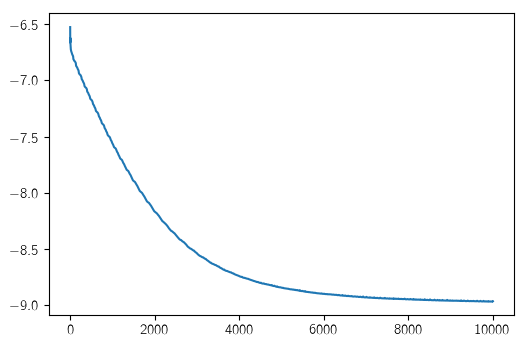

In [20]:
plt.plot(cost_hist)

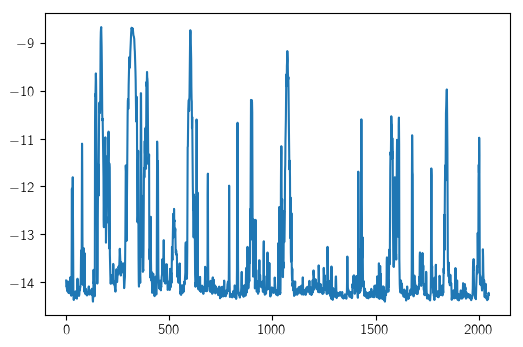

In [21]:
plt.plot(log_jitter_pix_res[0])

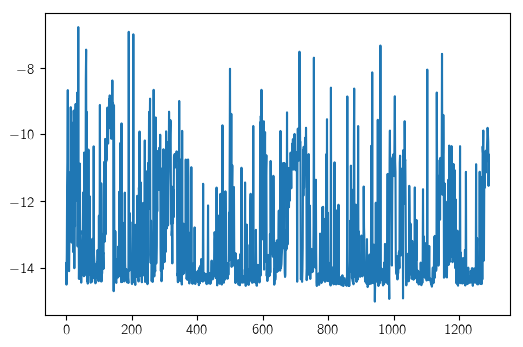

In [22]:
plt.plot(log_jitter_star_res[:, 0])

[ 133  137  120 ..., 1287 1279 1271]


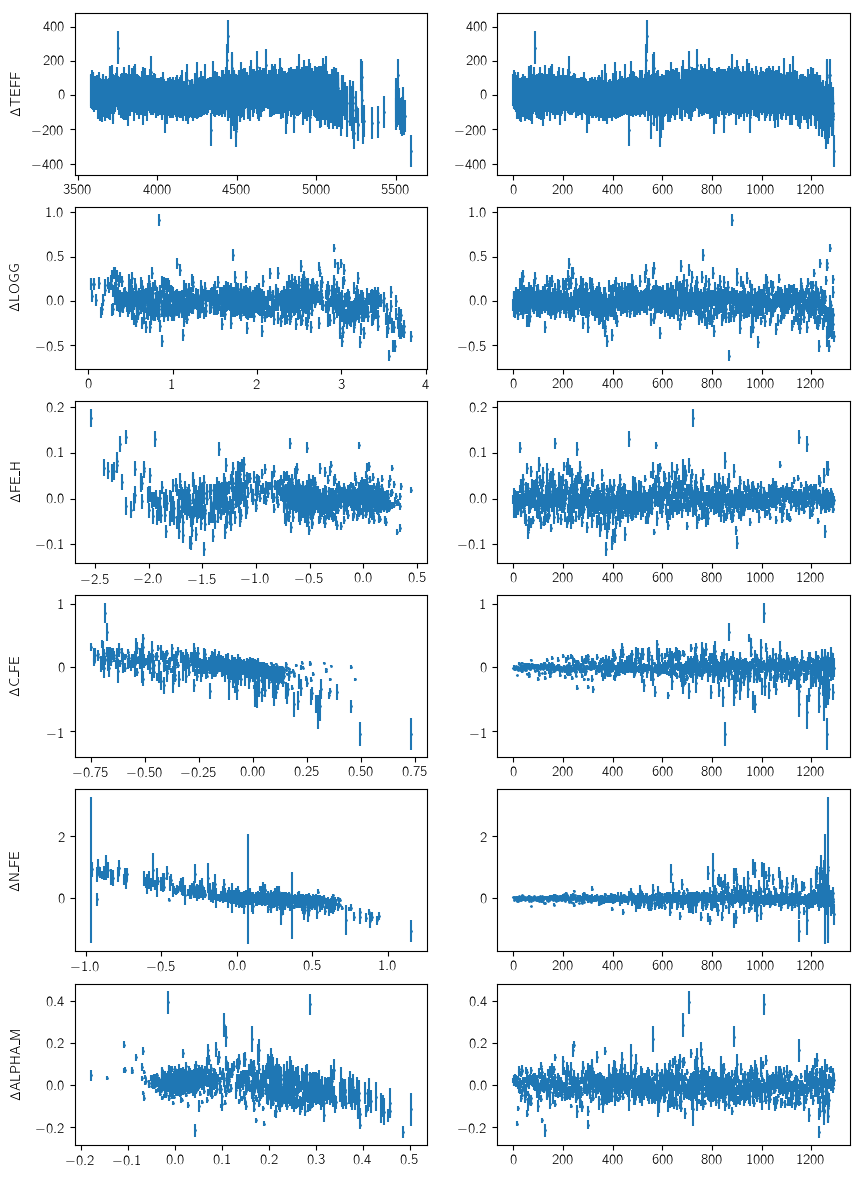

In [23]:
fig, axes = plt.subplots(n_label, 2, figsize=(10, 15))
inds = np.argsort(train_labels[:, 0])
print(inds)
for ind in range(n_label):
    pred = L_res[:, ind] * std[ind] + mu[ind]
    ax = axes[ind, 0]
    y = pred - train_labels[:, ind]
    yerr = 1.0/np.sqrt(train_label_ivar[:, ind])
    ax.errorbar(train_labels[:, ind], y, yerr=yerr, fmt=".", capsize=0, ms=2)
    ax.set_ylabel("$\Delta$" + label_names[ind].replace("_", "\_"))
    ax.yaxis.set_label_coords(-0.15, 0.5)
    
    ax = axes[ind, 1]
    ax.errorbar(np.arange(n_star), y[inds], yerr=yerr[inds], fmt=".", capsize=0, ms=2)
    
fig.savefig("deltas.pdf", bbox_inches="tight")

In [24]:
ind = 0
blah = np.argmax(np.abs(train_labels[:, ind] - pred))
blah

1271

In [25]:
D = get_design(Z_init, 0.0, 1.0, order=flux_order)
mod = np.dot(D[blah], W_flux_init.T)

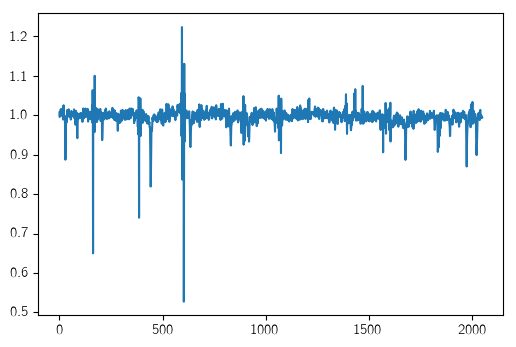

In [26]:
plt.plot(train_flux[blah])

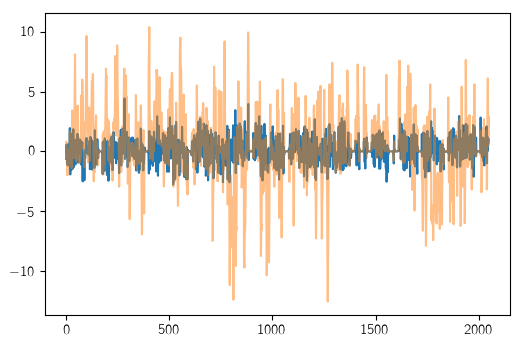

In [27]:
ivar = 1.0 / (1.0 / train_ivar[blah] + np.exp(log_jitter_pix_res[0]) + np.exp(log_jitter_star_res[blah, 0]))
plt.plot((F_res[blah] - train_flux[blah]) * np.sqrt(ivar))
plt.plot((mod - train_flux[blah]) * np.sqrt(ivar), alpha=0.5)

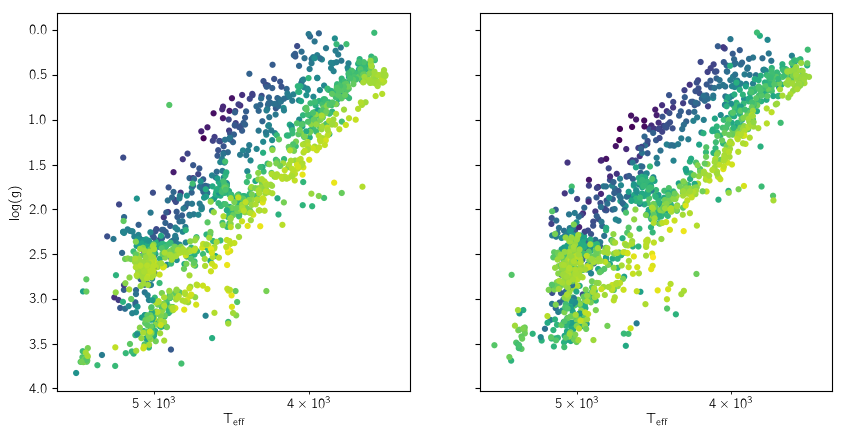

In [28]:
pred_labels = L_res * std + mu

fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)

ax = axes[0]
ax.scatter(train_labels[:, 0], train_labels[:, 1], c=train_labels[:, 2], s=20, edgecolor="none")
ax.set_ylabel("log(g)")
ax.set_xlabel("T$_\mathrm{eff}$")

ax = axes[1]
ax.scatter(pred_labels[:, 0], pred_labels[:, 1], c=pred_labels[:, 2], s=20, edgecolor="none")
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_ylim(ax.get_ylim()[::-1])
ax.set_xscale("log")
ax.set_xlabel("T$_\mathrm{eff}$")

fig.savefig("hr.pdf", bbox_inches="tight")

In [5]:
order = 2
D = get_design(train_labels, mu, std, order=order)
weights = np.empty((D.shape[1], train_flux.shape[1]))
for n in range(train_flux.shape[1]):
    weights[:, n] = np.linalg.solve(np.dot(D.T, D * train_ivar[:, n][:, None]), np.dot(D.T, train_ivar[:, n]*train_flux[:, n]))

In [6]:
weights.shape

(10, 1050)

In [7]:
learning_rate = 0.01
n_star, n_pix = train_flux.shape
n_labels = train_labels.shape[1]

In [8]:
F = tf.convert_to_tensor(train_flux, dtype=tf.float32)
F_ivar = tf.convert_to_tensor(train_ivar, dtype=tf.float32) 
L = tf.convert_to_tensor(train_labels, dtype=tf.float32)
L_ivar = tf.convert_to_tensor(train_label_ivar, dtype=tf.float32)

In [164]:
# A_norm = (train_labels - mu) / std
As = [tf.Variable(tf.convert_to_tensor((train_labels[:, i:i+1] - mu[i]) / std[i], dtype=tf.float32),
                  name="A_{0}".format(i))
      for i in range(n_labels)]
Ws = [tf.Variable(tf.convert_to_tensor(weights[i:i+1], dtype=tf.float32),
                  name="W_{0}".format(i))
      for i in range(len(weights))]

j = 1
F_ = tf.matmul(tf.ones((n_star, 1), dtype=tf.float32), Ws[0])
for o in range(1, order + 1):
    for inds in combinations_with_replacement(range(n_labels), o):
        m = tf.ones((n_star, 1), dtype=tf.float32)
        for i in inds:
            m = tf.multiply(m, As[i])
        F_ += tf.matmul(m, Ws[j])
        j += 1

In [165]:
log_jitter = tf.Variable(-8.0 + tf.zeros((n_star, 1)), name="log_jitter")

In [166]:
ivar = 1.0 / (1.0 / F_ivar + tf.exp(log_jitter))
cost = tf.reduce_sum(tf.multiply(tf.square(F_ - F), ivar))
cost -= tf.reduce_sum(tf.log(ivar))
for i in range(n_labels):
    cost += tf.reduce_sum(tf.multiply(tf.square(As[i][:, 0] * std[i] + mu[i] - L[:, i]), L_ivar[:, i]))
cost /= n_star * n_pix
var_grad = tf.gradients(cost, As + Ws)

# training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost, var_list=Ws)
training_step = tf.train.AdamOptimizer().minimize(cost, var_list=Ws + As + [log_jitter])

In [167]:
init = tf.global_variables_initializer()

In [179]:
import tqdm
cost_hist = []
with tf.Session() as sess:
    r1 = sess.run(init)

#     result = sess.run(cost)
#     r1 = sess.run(init)
#     print(r1)
#     print(sess.run(var_grad))
    for i in tqdm.trange(5000):
        sess.run(training_step)
        cost_hist.append(sess.run(cost))
        
    W_res = sess.run(Ws)
    A_res = sess.run(As)
    F_res = sess.run(F_)
    log_jitter_res = sess.run(log_jitter)

100%|██████████| 5000/5000 [04:08<00:00, 20.15it/s]


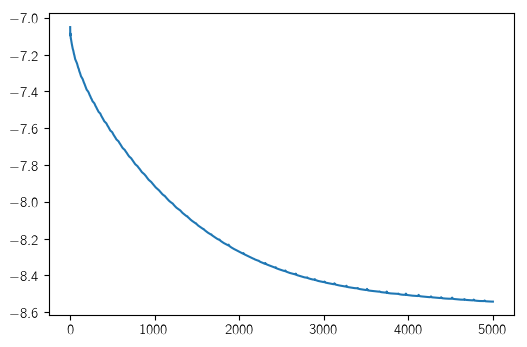

In [180]:
plt.plot(cost_hist)

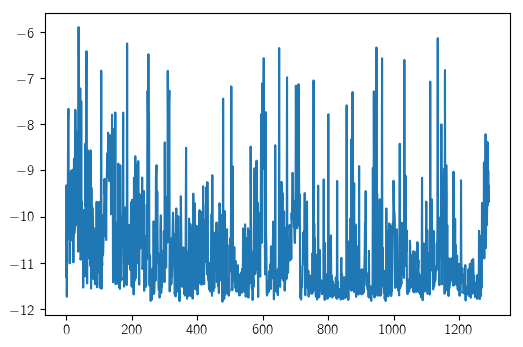

In [181]:
plt.plot(log_jitter_res[:, 0])

4085937.80908
7781527.54317


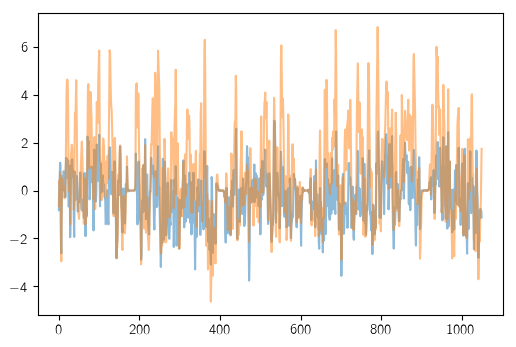

In [182]:
i = 0
plt.plot((train_flux[i] - F_res[i]) * np.sqrt(train_ivar[i]), alpha=0.5)
plt.plot((train_flux[i] - np.dot(D[i], weights)) * np.sqrt(train_ivar[i]), alpha=0.5)
print(np.sum((train_flux - F_res)**2 * train_ivar))
print(np.sum((train_flux - np.dot(D, weights))**2 * train_ivar))

<Container object of 3 artists>

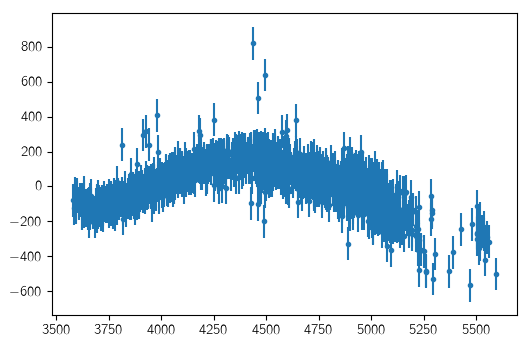

In [189]:
ind = 0
pred = A_res[ind][:, 0] * std[ind] + mu[ind]
plt.errorbar(train_labels[:, ind], pred - train_labels[:, ind],
             yerr=1.0/np.sqrt(train_label_ivar[:, ind]),
             fmt=".", capsize=0)

In [92]:
A_0 = tf.ones((n_star, 1), dtype=tf.float32)
W_0 = tf.convert_to_tensor(weights[:1], dtype=tf.float32)

A_1 = A
W_1 = tf.convert_to_tensor(weights[1:1+n_labels], dtype=tf.float32)

A_2 = tf.multiply(A, A)
W_2 = tf.convert_to_tensor(weights[1+n_labels:1+2*n_labels], dtype=tf.float32)

f_ = tf.matmul(A_0, W_0) + tf.matmul(A_1, W_1) + tf.matmul(A_2, W_2)
cost = tf.reduce_sum(tf.multiply(tf.square(f_ - F), F_ivar))
cost += tf.reduce_sum(tf.multiply(tf.square(A - L), L_ivar))
var_grad = tf.gradients(cost, [W_0, W_1, W_2, A_1])

training_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

In [93]:
with tf.Session() as sess:
    r1 = A.initializer.run()
    print(r1)
    result = sess.run(var_grad)

None


In [94]:
[r.shape for r in result]

[(1, 1050), (3, 1050), (3, 1050), (1301, 3)]

In [95]:
result

[array([[-2.72045898,  2.1583252 ,  3.0390625 , ...,  1.76464844,
         -2.42089844, -1.13183594]], dtype=float32),
 array([[ 0.24707031, -0.08007812, -0.17480469, ...,  0.1328125 ,
          0.14453125,  0.18554688],
        [ 0.18164062, -0.04785156, -0.15039062, ...,  0.03125   ,
          0.1953125 ,  0.1640625 ],
        [-0.1138916 ,  0.16540527,  0.21899414, ...,  0.05664062,
         -0.08007812,  0.01269531]], dtype=float32),
 array([[-2.81152344,  2.18164062,  3.10546875, ...,  1.71875   ,
         -2.5703125 , -1.21484375],
        [-2.91210938,  2.00390625,  3.0859375 , ...,  1.671875  ,
         -2.4765625 , -1.078125  ],
        [-2.5569458 ,  1.95178223,  2.93310547, ...,  1.54980469,
         -2.28125   , -1.29199219]], dtype=float32),
 array([[ 52831.6875    ,  20636.59960938,  -7519.14257812],
        [-20789.14453125,   2621.80126953,   6067.38232422],
        [-19653.91796875,   5147.72363281,   7659.609375  ],
        ..., 
        [  8404.35839844,  -2620.01123